In [1]:
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px

### Load data

In [2]:
data = pd.read_csv('billboard_24years_lyrics_spotify_with_genres.csv')

# Remove rows containing NaN values in the 'genre'
data = data.dropna(subset=['genre'])

In [3]:
## Make data frame with all data
data_all = data.copy()

In [4]:
## Make data frame with single entry per songurl
data_single = data.copy()

# Songs that appear more than once in the dataset
duplicated_songurls = data[data.duplicated(subset=['songurl'], keep=False)]['songurl'].unique()

for songurl in duplicated_songurls[:10]:
    rows = data[data['songurl'] == songurl]
    
    # Combine rows by collecting band_singer and url as lists of unique elements
    combined_band_singer = list(rows['band_singer'].unique())
    combined_url = list(rows['url'].unique())

    danceability = rows['danceability'].mean()
    energy = rows['energy'].mean()
    key = rows['key'].mean()
    loudness = rows['loudness'].mean()
    mode = rows['mode'].mean()
    speechiness = rows['speechiness'].mean()
    acousticness = rows['acousticness'].mean()
    instrumentalness = rows['instrumentalness'].mean()
    liveness = rows['liveness'].mean()
    valence = rows['valence'].mean()
    tempo = rows['tempo'].mean()
    duration_ms = rows['duration_ms'].mean()


    # Create a new row with combined information
    new_row = rows.iloc[0].copy()
    new_row['band_singer'] = combined_band_singer
    new_row['url'] = combined_url
    new_row['danceability'] = danceability
    new_row['energy'] = energy
    new_row['key'] = key
    new_row['loudness'] = loudness
    new_row['mode'] = mode
    new_row['speechiness'] = speechiness
    new_row['acousticness'] = acousticness
    new_row['instrumentalness'] = instrumentalness
    new_row['liveness'] = liveness
    new_row['valence'] = valence
    new_row['tempo'] = tempo
    new_row['duration_ms'] = duration_ms

    # Drop the original rows and append the new combined row
    data_single = data_single[data_single['songurl'] != songurl]
    data_single.loc[len(data_single)] = new_row

# Sort data_single by ranking
data_single = data_single.sort_values(by='ranking').reset_index(drop=True)

### Basic statistics

In [5]:
## Basic statistics of genres
df_genres = data_single[data_single['genre'].apply(bool)].reset_index(drop=True)

df_genres['genre'] = (
    df_genres['genre']
      .astype(str)
      .apply(lambda x: [g.strip() for g in x.split(',')] if ',' in x else [x.strip()])
)


Number of artists with genres: 3057
Average number of genres per artist: 2.1995420346745176
Total distinct genres: 327


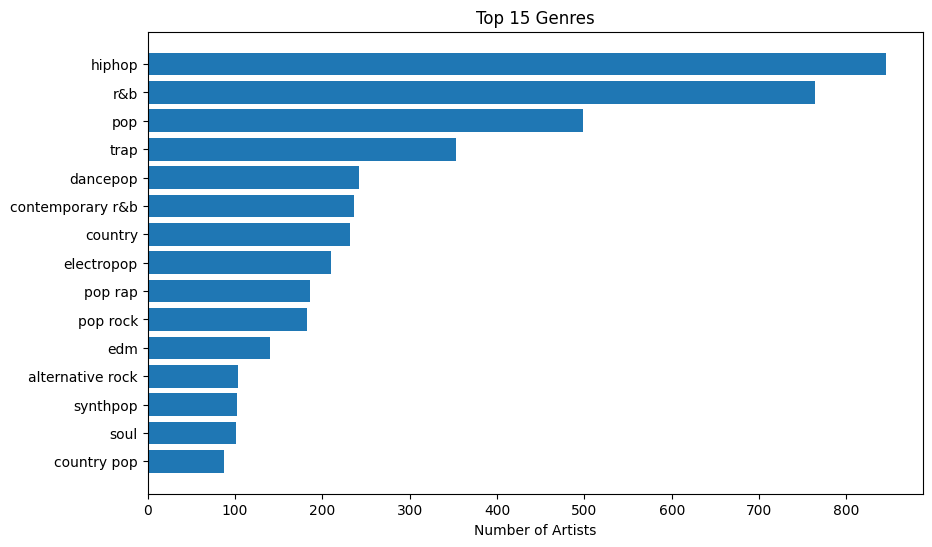

In [6]:

# --- Stats ---
num_artists_with_genres = len(df_genres)
avg_genres_per_artist = sum(len(genres) for genres in df_genres['genre']) / num_artists_with_genres
all_genres = [g for genres in df_genres['genre'] for g in genres]
num_distinct_genres = len(set(all_genres))
genre_counts = Counter(all_genres)

print("Number of artists with genres:", num_artists_with_genres)
print("Average number of genres per artist:", avg_genres_per_artist)
print("Total distinct genres:", num_distinct_genres)

# --- Histogram (top 15 genres) ---
if genre_counts:
    top = genre_counts.most_common(15)
    names, counts = zip(*top)
    plt.figure(figsize=(10,6))
    plt.barh(names[::-1], counts[::-1])
    plt.xlabel("Number of Artists")
    plt.title("Top 15 Genres")
    plt.show()

### Networks 

In [7]:
import networkx as nx
import pandas as pd
from collections import defaultdict, Counter
from multiprocessing import Pool, cpu_count

# Read emotion data
df_emo = pd.read_csv(
    'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt',
    sep='\t',
    header=None,
    names=['word', 'emotion', 'association']
)

In [8]:
## Remove genres with less than 5 artists
filtered_genres = {genre for genre, count in genre_counts.items() if count >= 5}
df_genres['genre'] = df_genres['genre'].apply(lambda genres: [g for g in genres if g in filtered_genres])
df_genres = df_genres[df_genres['genre'].apply(bool)].reset_index(drop=True)

In [11]:
## Expand dataframe so each genre has its own row
df_expanded = df_genres.explode('genre').reset_index(drop=True)

In [28]:
## Function to map song lyrics to emotions and count frequency

def map_song_to_emotions_count(song_lyrics: str, word_to_emotions: dict) -> dict:
    """
    Map words in a song's lyrics to emotions and count frequency.
    Returns a dictionary: emotion -> count of words
    """
    words = song_lyrics.lower().split()
    emotion_counts = Counter()
    for word in words:
        if word in word_to_emotions:
            for emotion in word_to_emotions[word]:
                emotion_counts[emotion] += 1
    return dict(emotion_counts)

# --- Main execution ---
if __name__ == "__main__":
    # Step 1: Filter emotions with association == 1
    df_emo_ones = df_emo[df_emo['association'] == 1]

    # Step 2: Pre-build word -> emotion mapping
    word_to_emotions = defaultdict(list)
    for _, row in df_emo_ones.iterrows():
        word_to_emotions[row['word']].append(row['emotion'])

    # Step 3: Prepare song lyrics list
    songs_lyrics = df_expanded['lyrics'].tolist()

    # Step 4: Define worker for multiprocessing
    def worker_map_song(lyrics):
        return map_song_to_emotions_count(lyrics, word_to_emotions)

    # Step 5: Sequential processing (no parallelism)
    emotion_dicts = [worker_map_song(lyrics) for lyrics in songs_lyrics]

    # Step 6: Convert list of dicts to DataFrame and combine
    df_emotions = pd.DataFrame(emotion_dicts).fillna(0)
    df_songs_with_emotions = pd.concat([df_expanded.reset_index(drop=True), df_emotions.reset_index(drop=True)], axis=1)



In [40]:
## Find average emotion per genre
emotion_cols = ['anticipation','fear','joy','positive','trust',
                'anger','disgust','negative','sadness','surprise']

df_emotions_by_genre = (
    df_songs_with_emotions
        .groupby('genre')[emotion_cols]
        .mean()
        .reset_index()
)

# # Most dominant emotion per genre
df_emotions_by_genre['dominant_emotion'] = df_emotions_by_genre[emotion_cols].idxmax(axis=1)


In [ ]:
## Expand to have column with positive/negative and a column with dominant emotion
def dominant_sentiment(row):
    if row['positive'] >= row['negative']:
        return 'positive'
    else:
        return 'negative'
    
def dominant_emotion(row):
    sorted_emotions = row[emotion_cols].sort_values(ascending=False)
    if sorted_emotions.index[0] in ['positive', 'negative']:
        if sorted_emotions.index[1] in ['positive', 'negative']:
            return sorted_emotions.index[2]
        return sorted_emotions.index[1]
    else:
        return row[emotion_cols].idxmax()


df_emotions_by_genre['sentiment'] = df_emotions_by_genre.apply(dominant_sentiment, axis=1)
df_emotions_by_genre['dominant_emotion'] = df_emotions_by_genre.apply(dominant_emotion, axis=1)


## Most dominant emotion

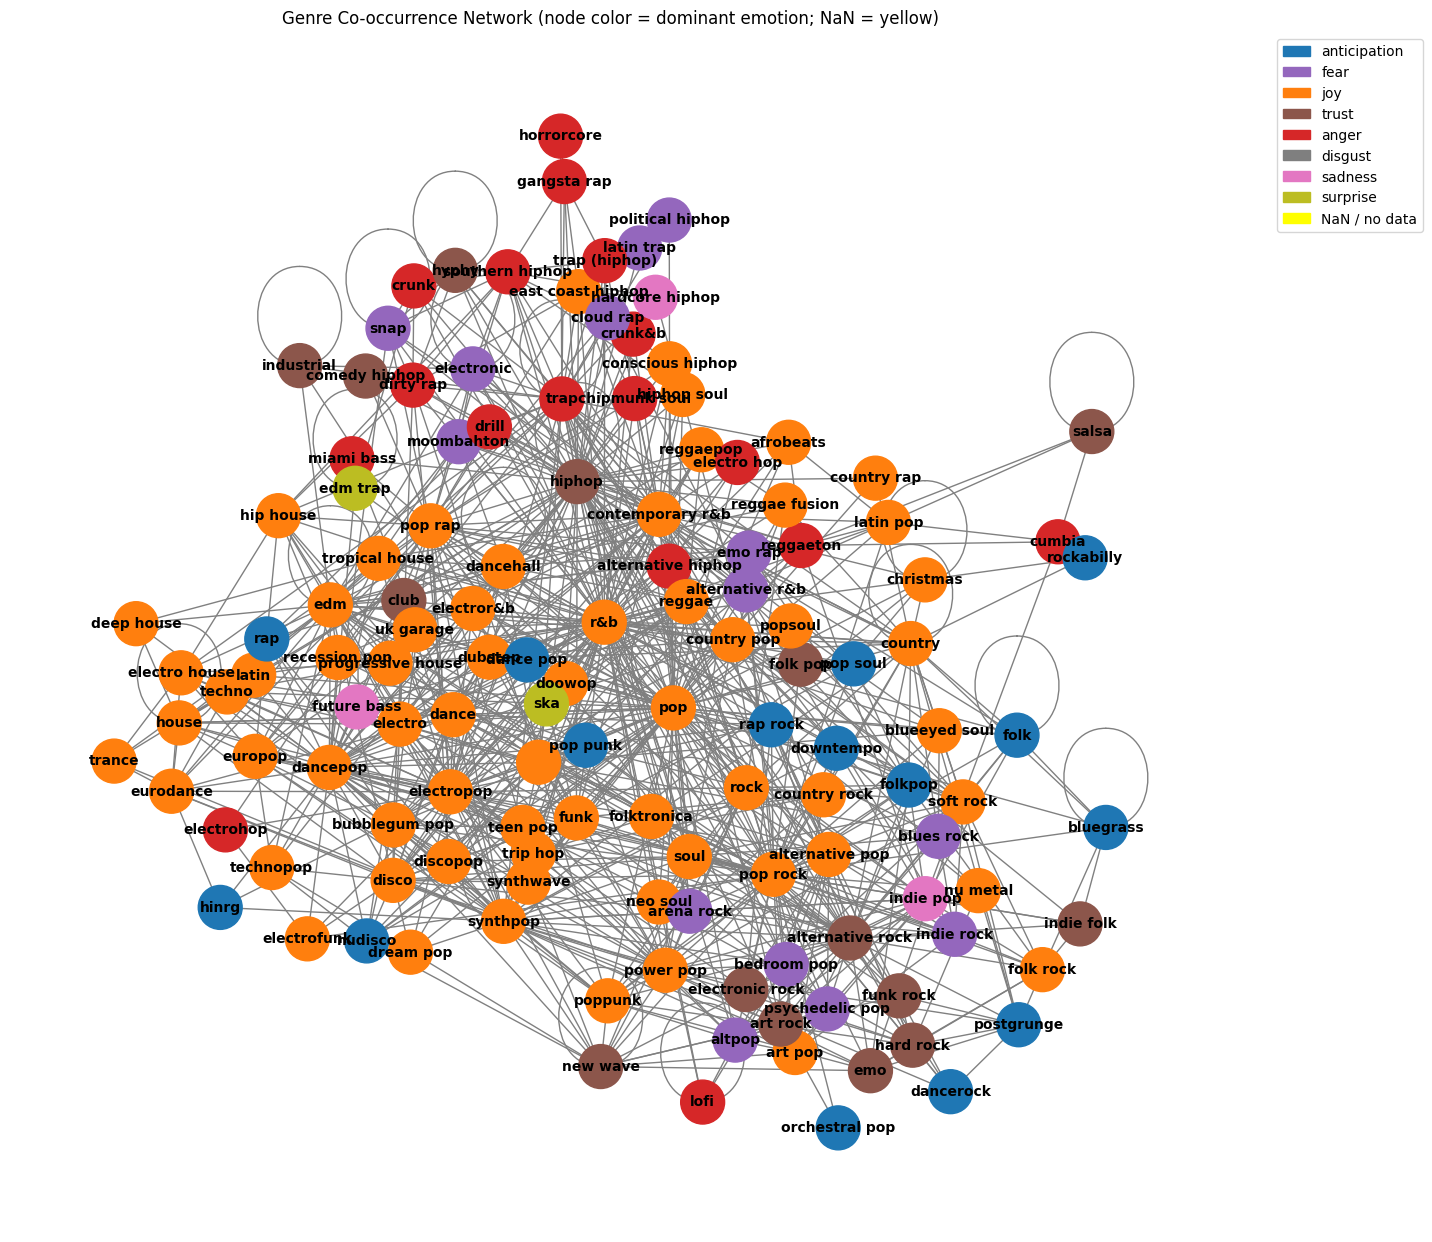

In [57]:
## Create graph with genres as nodes and links being the artist with both genres
G = nx.Graph()
for genres in df_genres['genre']:
    if len(genres) > 1:
        for i in range(len(genres)):
            for j in range(i + 1, len(genres)):
                genre1 = genres[i]
                genre2 = genres[j]
                if G.has_edge(genre1, genre2):
                    G[genre1][genre2]['weight'] += 1
                else:
                    G.add_edge(genre1, genre2, weight=1)

# Map emotions to colors
emotion_color_map = {
    'anticipation': '#1f77b4',
    'fear':         '#9467bd',
    'joy':          '#ff7f0e',
    # 'positive':     '#2ca02c',
    'trust':        '#8c564b',
    'anger':        '#d62728',
    'disgust':      '#7f7f7f',
    # 'negative':     '#17becf',
    'sadness':      '#e377c2',
    'surprise':     '#bcbd22'
}
nan_color = 'yellow'

# Build node color list based on dominant emotion per genre
node_colors = []
for node in G.nodes():
    row = df_emotions_by_genre[df_emotions_by_genre['genre'] == node]
    if not row.empty and pd.notna(row['dominant_emotion'].iloc[0]):
        dom = row['dominant_emotion'].iloc[0]
        node_colors.append(emotion_color_map.get(dom, nan_color))
    else:
        node_colors.append(nan_color)

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.forceatlas2_layout(G, max_iter=1000, seed=42)

nx.draw(G, pos,
        with_labels=True,
        node_size=1000,
        node_color=node_colors,
        font_size=10,
        font_weight="bold",
        edge_color="gray")

# Optional: show a legend for emotions
patches = [mpatches.Patch(color=c, label=e) for e, c in emotion_color_map.items()]
patches.append(mpatches.Patch(color=nan_color, label='NaN / no data'))
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Genre Co-occurrence Network (node color = dominant emotion; NaN = yellow)")
plt.show()


## Dominant positive/negative/neutral

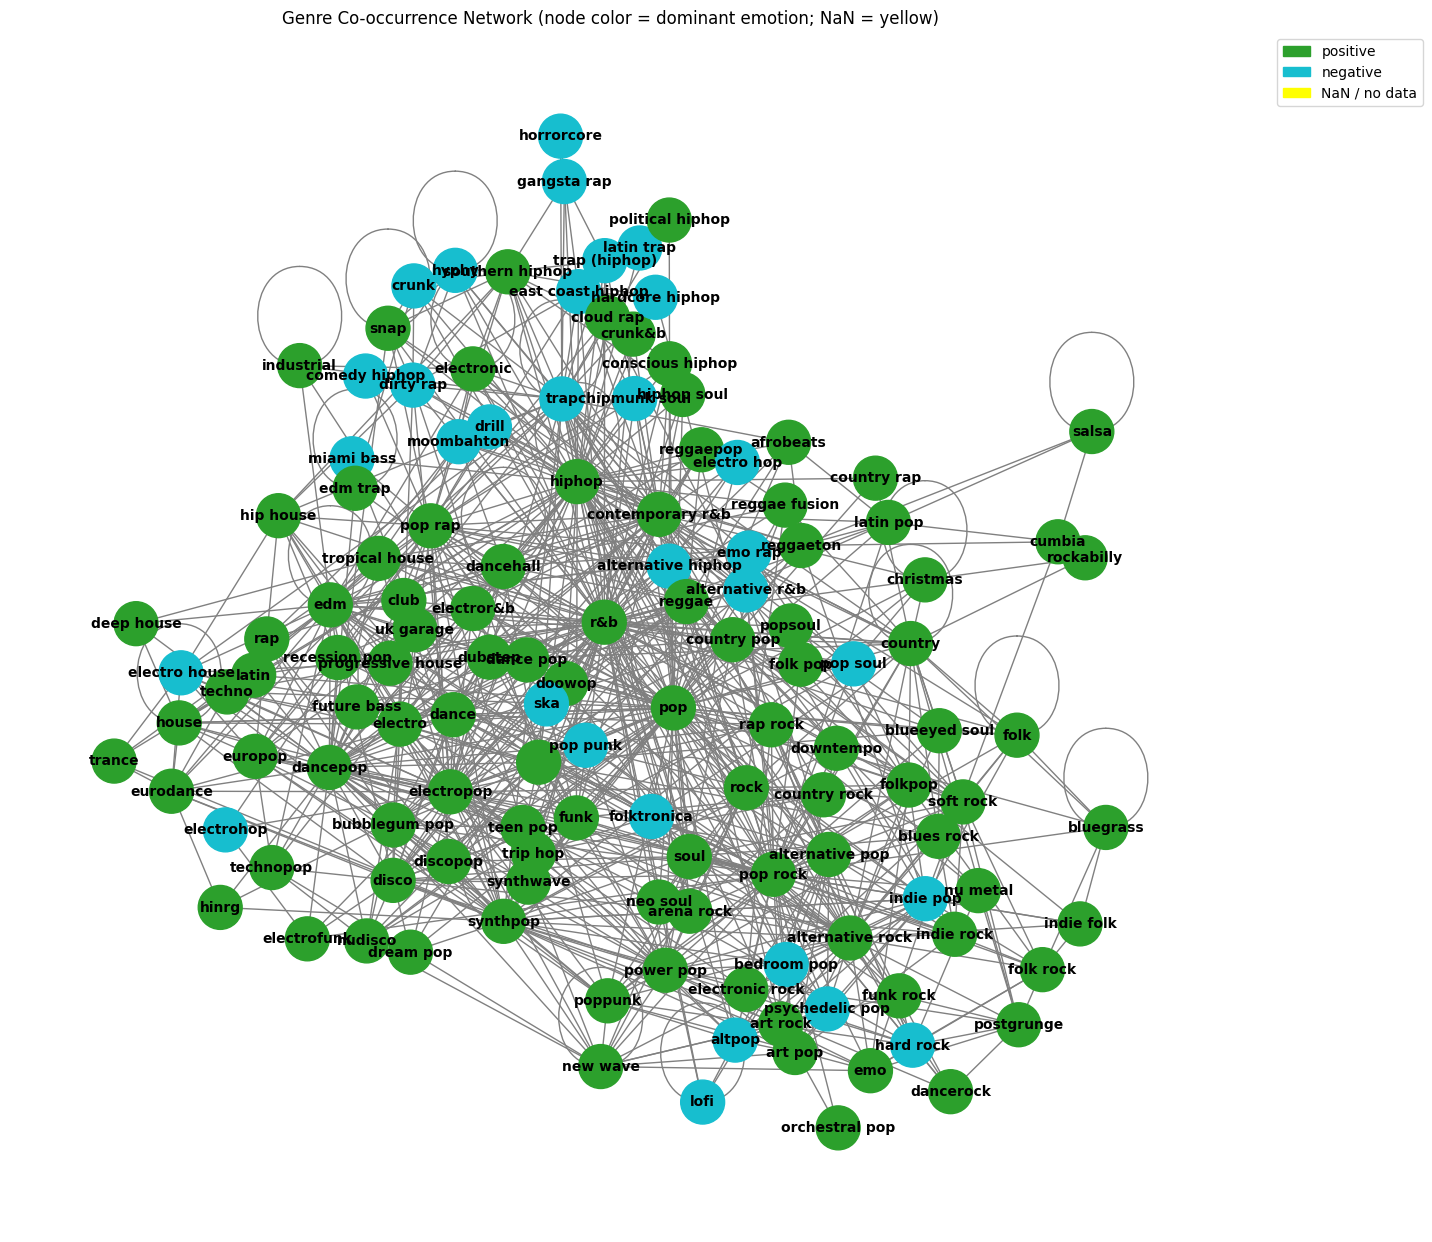

In [58]:
## Create graph with genres as nodes and links being the artist with both genres
G_ps = nx.Graph()
for genres in df_genres['genre']:
    if len(genres) > 1:
        for i in range(len(genres)):
            for j in range(i + 1, len(genres)):
                genre1 = genres[i]
                genre2 = genres[j]
                if G_ps.has_edge(genre1, genre2):
                    G_ps[genre1][genre2]['weight'] += 1
                else:
                    G_ps.add_edge(genre1, genre2, weight=1)

# Map emotions to colors
emotion_color_map = {
    'positive':     '#2ca02c',
    'negative':     '#17becf'
}
nan_color = 'yellow'

# Build node color list based on dominant emotion per genre
node_colors = []
for node in G_ps.nodes():
    row = df_emotions_by_genre[df_emotions_by_genre['genre'] == node]
    if not row.empty and pd.notna(row['sentiment'].iloc[0]):
        dom = row['sentiment'].iloc[0]
        node_colors.append(emotion_color_map.get(dom, nan_color))
    else:
        node_colors.append(nan_color)

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.forceatlas2_layout(G_ps, max_iter=1000, seed=42)

nx.draw(G_ps, pos,
        with_labels=True,
        node_size=1000,
        node_color=node_colors,
        font_size=10,
        font_weight="bold",
        edge_color="gray")

# Optional: show a legend for emotions
patches = [mpatches.Patch(color=c, label=e) for e, c in emotion_color_map.items()]
patches.append(mpatches.Patch(color=nan_color, label='NaN / no data'))
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Genre Co-occurrence Network (node color = dominant emotion; NaN = yellow)")
plt.show()


### Betweenness centriality

In [59]:
## Betweenness centrality
betweenness = nx.betweenness_centrality(G)
print("Betweenness Centrality:")
for genre, centrality in betweenness.items():
    print(f"{genre}: {centrality:.4f}")

Betweenness Centrality:
trap: 0.0599
southern hiphop: 0.0033
pop rap: 0.0429
pop: 0.1024
dancehall: 0.0032
tropical house: 0.0043
alternative rock: 0.0362
postgrunge: 0.0010
folk: 0.0007
blueeyed soul: 0.0007
funk: 0.0063
soul: 0.0073
discopop: 0.0001
: 0.0111
country pop: 0.0064
r&b: 0.1515
neo soul: 0.0003
comedy hiphop: 0.0000
art pop: 0.0011
hard rock: 0.0022
dancepop: 0.0661
electropop: 0.0576
edm: 0.0377
hiphop: 0.1320
electro: 0.0037
miami bass: 0.0000
country: 0.0287
pop rock: 0.1109
crunk&b: 0.0000
synthpop: 0.0379
new wave: 0.0039
synthwave: 0.0007
east coast hiphop: 0.0015
gangsta rap: 0.0010
psychedelic pop: 0.0005
disco: 0.0125
nudisco: 0.0006
reggaeton: 0.0137
latin pop: 0.0121
soft rock: 0.0090
downtempo: 0.0006
moombahton: 0.0002
contemporary r&b: 0.0467
teen pop: 0.0008
bubblegum pop: 0.0040
electronic rock: 0.0001
dance: 0.0084
doowop: 0.0001
arena rock: 0.0028
indie rock: 0.0006
indie pop: 0.0153
hiphop soul: 0.0000
latin: 0.0000
electronic: 0.0021
electrohop: 0.0001